In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = "cover"
print(target)

display(train[target].head(3))

cover


0    0.050
1    0.725
2    0.025
Name: cover, dtype: float64

In [9]:
train_missing_40 = train_missing[train_missing.percent<0.4].index
test_missing_40 =  test_missing[test_missing.percent<0.4].index
train_missing_15 = train_missing[train_missing.percent<0.15].index
test_missing_15 =  test_missing[test_missing.percent<0.15].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features_40 = set(train_missing_40) & set(test_missing_40)
features_15 = set(train_missing_15) & set(test_missing_15)
features = set(features_40) - set(categorical_features)
knn_features = set(features) - set(features_15)  

In [10]:
len(features), len(knn_features)

(2259, 512)

In [11]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]
knn_features = [col for col in knn_features if col not in land_sat_feats]

In [12]:
len(features), len(knn_features)

(309, 62)

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

missing_train = train.fillna(9999)
missing_test = test.fillna(9999)

for mcol in tqdm(knn_features):
    knn_mtrain = missing_train.loc[missing_train[mcol]==9999]
    knn_train = missing_train.loc[missing_train[mcol]!=9999]
    knn_mtest = missing_test.loc[missing_test[mcol]==9999]

    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(knn_train[features],knn_train[mcol])
    knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
    knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])

    train = train.merge(knn_mtrain[["id",f"knn_{mcol}"]],how="left",on="id")
    train[mcol] = train[mcol].fillna(0)
    train[f"knn_{mcol}"] = train[f"knn_{mcol}"].fillna(0)
    train[mcol] = train[mcol] + train[f"knn_{mcol}"]

    test = test.merge(knn_mtest[["id",f"knn_{mcol}"]],how="left",on="id")
    test[mcol] = test[mcol].fillna(0)
    test[f"knn_{mcol}"] = test[f"knn_{mcol}"].fillna(0)
    test[mcol] = test[mcol] + test[f"knn_{mcol}"]

display(train[knn_features].head(10))
display(test[knn_features].head(10))

  0%|          | 0/62 [00:00<?, ?it/s]<ipython-input-13-b25a66a67f2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
<ipython-input-13-b25a66a67f2a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])
  2%|▏         | 1/62 [00:02<02:27,  2.41s/it]<ipython-input-13-b25a66a67f2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,D678_500,NLI,Green,SWIR2,NBR2,Cigreen,AVI,GEMI,Gossan,NDMI,...,Ferric_Oxides,CTVI,H,NDVI,NormG,NDWI,sunAzimuth,Alteration,Chlred_edge,SIPI2
0,-32.222498,0.243821,24.466267,0.126413,0.369581,-0.816220,-15.589754,-65.107007,0.022344,0.884876,...,0.061078,0.410823,1.536542,-0.464321,0.593065,0.689504,147.348267,2.172491,2.733582,5.133805
1,-25.819462,0.979600,72.848259,1.017969,0.724646,-0.034399,38.705406,-351.833930,0.125043,0.833784,...,0.090641,0.568762,1.410671,0.159502,0.375158,0.017501,95.422757,6.263373,0.724878,-0.334153
2,-32.615326,0.535998,34.678707,0.114172,0.697570,-0.774456,-21.318088,-120.471556,0.034677,0.848540,...,0.081935,0.441918,1.532755,-0.405253,0.568682,0.631929,151.061766,5.613106,2.362776,4.059874
3,-24.054768,0.848795,46.825167,0.341719,0.722703,-0.467946,-17.434855,-127.003226,0.067277,0.838246,...,0.088156,0.580183,1.495565,-0.177638,0.448051,0.324695,127.929376,6.416499,1.554244,5.472865
4,-48.243380,0.337366,30.404083,0.036060,0.710619,-0.852835,-10.890392,-32.365638,0.021489,0.909053,...,0.047640,-0.089450,1.554811,-0.378296,0.678692,0.743429,153.361999,5.911293,2.216966,9.859806
5,-24.054768,0.848795,46.825167,0.341719,0.722703,-0.467946,-17.434855,-127.003226,0.067277,0.838246,...,0.088156,0.580183,1.495565,-0.177638,0.448051,0.324695,127.929376,6.416499,1.554244,5.472865
6,-35.144657,0.465244,30.243046,0.087500,0.709369,-0.787863,-17.212898,-79.293798,0.034259,0.851482,...,0.080216,0.404647,1.540411,-0.401461,0.585189,0.649978,151.061766,5.881573,2.341471,5.083526
7,-56.048031,0.169172,55.338951,0.148056,0.634860,-0.905826,-28.176980,-206.976268,0.034347,0.774309,...,0.127199,0.130981,1.554245,-0.574771,0.693033,0.827863,128.531133,4.477353,3.703350,4.978285
8,-45.133583,0.568627,38.484325,0.198072,0.620597,-0.791823,-19.278593,-99.085508,0.047933,0.808965,...,0.105604,0.358983,1.551772,-0.375620,0.599942,0.655387,126.264466,4.271438,2.203177,5.682249
9,-34.878019,0.346556,26.254721,0.086716,0.683367,-0.813486,-13.479237,-49.117164,0.039619,0.827909,...,0.094146,0.337943,1.540390,-0.407637,0.613599,0.685610,153.816328,5.316467,2.376309,6.175073


,D678_500,NLI,Green,SWIR2,NBR2,Cigreen,AVI,GEMI,Gossan,NDMI,...,Ferric_Oxides,CTVI,H,NDVI,NormG,NDWI,sunAzimuth,Alteration,Chlred_edge,SIPI2
0,-24.054768,0.848795,46.825167,0.341719,0.722703,-0.467946,-17.434855,-127.003226,0.067277,0.838246,...,0.088156,0.580183,1.495565,-0.177638,0.448051,0.324695,127.929376,6.416499,1.554244,5.472865
1,-40.491771,0.658823,35.449848,0.203959,0.625434,-0.746453,-13.141754,-50.269846,0.057763,0.818370,...,0.100038,0.324673,1.544322,-0.271374,0.592326,0.597267,128.573050,4.433743,1.749661,7.369578
2,-24.153577,0.883218,46.699800,0.365417,0.707265,-0.442532,-15.260981,-90.264924,0.068976,0.840804,...,0.086700,0.581877,1.497484,-0.144751,0.441041,0.295492,127.929376,6.189369,1.390758,5.576378
3,-43.907300,0.211141,28.700424,0.033908,0.787176,-0.854896,-14.263588,-54.702543,0.025207,0.872004,...,0.068374,0.254681,1.552029,-0.461280,0.649900,0.746567,138.032189,8.397437,2.712507,7.156558
4,-32.710871,0.147521,42.104111,0.096436,0.665161,-0.864626,-36.870170,-351.078729,0.019871,0.844782,...,0.084139,0.478249,1.529995,-0.617907,0.585277,0.761533,154.492638,4.973023,4.234328,2.774381
5,-25.056278,0.843519,45.417629,0.337050,0.708617,-0.469185,-15.247592,-89.876426,0.066737,0.842444,...,0.085772,0.570722,1.503037,-0.170528,0.452128,0.326208,127.929376,6.207093,1.514408,5.637460
6,-40.057273,0.435992,29.240328,0.085234,0.560829,-0.807151,-13.700280,-50.800409,0.024255,0.898038,...,0.053720,0.313967,1.547764,-0.377875,0.617296,0.676659,153.816328,3.554037,2.214788,6.847657
7,-45.234715,0.260737,37.272316,0.150323,0.614958,-0.865938,-19.287441,-98.665395,0.043065,0.775917,...,0.126179,0.253065,1.550916,-0.491092,0.654939,0.763572,132.150790,4.194235,2.929983,5.690587
8,-34.561496,0.455053,28.144505,0.050833,0.812505,-0.794776,-13.437099,-48.937543,0.039329,0.843186,...,0.085077,0.338970,1.538688,-0.367729,0.606368,0.659443,153.816328,9.666928,2.163200,6.144190
9,-24.054768,0.848795,46.825167,0.341719,0.722703,-0.467946,-17.434855,-127.003226,0.067277,0.838246,...,0.088156,0.580183,1.495565,-0.177638,0.448051,0.324695,127.929376,6.416499,1.554244,5.472865


## Model

In [14]:
#!pip install iterative-stratification

In [15]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold, TimeSeriesSplit
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [16]:
class CFG:
  ver=75
  model="lightgbm"
  n_folds=15
  trn_fold=[0, 1, 2, 3, 4, 5]
  seed=42
  boosting_type="gbdt"

In [17]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df):
  Fold = TimeSeriesSplit(n_splits=CFG.n_folds)
  for n, (train_index, val_index) in enumerate(Fold.split(df)):
    df.loc[train_index, f'tr_fold{n}'] = 1
    df.loc[val_index, 'va_fold'] = int(n)
    df[f"tr_fold{n}"] = df[f"tr_fold{n}"].fillna(0)
    df[f'tr_fold{n}'] = df[f'tr_fold{n}'].astype(int)
  df["va_fold"] = df["va_fold"].fillna(999)
  df['va_fold'] = df['va_fold'].astype(int)
  return df

In [18]:
def get_score(labels, preds):
  rmse = np.sqrt(mean_squared_error(labels, preds))
  print(f"RMSE {rmse}")

In [19]:
#features = list(features)
features.remove('id')
#features.remove('area')
features.remove("year")
#features.remove("month")
#features.append("mesh20")

In [20]:
params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'boosting': "dart",
        'seed': CFG.seed,
        "reg_alpha":0.1,
        #'reg_lambda': 0.5,
        "n_estimators":6000,
        'min_child_weight': 1,
        'colsample_bytree': 0.4
    }

In [21]:
def get_pred(df, test, params):
  oof_df = pd.DataFrame()
  #df_importance = pd.DataFrame({'feature': features})
  #df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))
  year_list = sorted(train.year.unique().tolist())

  for fold in range(6):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      y_v = fold + 6
      tr_ys = year_list[fold]
      tr_yl = year_list[fold+5]
      va_y = int(year_list[y_v])
      train_folds = train.loc[((train.year>=tr_ys) & (train.year<=tr_yl))]
      valid_folds = train.loc[train.year == va_y]

      print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
      print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target].values
      valid_labels = valid_folds[target].values

      #clf = model
      clf = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              #categorical_feature = ctg_list,
              verbose = 1000,
              early_stopping_rounds=50)
      
      valid_folds[f"pred"] = clf.predict(valid_X)
      test_preds[:, fold] = clf.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      #f_importance = np.array(clf.feature_importances_)
      #temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      #df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds["pred"])

  #df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  #df_importance = df_importance.sort_values('importance', ascending=False)
  #display(df_importance.head(35))
  #fig = plt.figure(figsize=(16, 32), tight_layout=True)
  #sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  #plt.title("LightGBM feature importances")
  get_score(oof_df[target], oof_df[f"pred"])
  return oof_df,  test_preds

In [22]:
train['year-month'] = train.year.astype(int).astype(str) + '-' + train.month.astype(int).astype(str)
train['year-month'] = pd.to_datetime(train['year-month'], format='%Y-%m')
train = train.sort_values("year-month").reset_index(drop=True)
#train = get_fold(train)
oof_preds = []
preds = np.zeros((len(test), 4))
seeds = [42, 18, 0, 2023]
for i in range(4):
  print("#"*15,f" SEED : {CFG.seed} ","#"*15)
  params["seed"] = seeds[i]
  oof_df, test_pred = get_pred(train, test, params)
  pred = np.mean(test_pred, axis=1)
  preds[:, i] = pred
  oof_preds.append(oof_df["pred"].values)
  print()

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2006.0年4.0月
valid period : 2009.0年1.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.302852
[2000]	valid_0's rmse: 0.307101
[3000]	valid_0's rmse: 0.303274
[4000]	valid_0's rmse: 0.304507
[5000]	valid_0's rmse: 0.306857
[6000]	valid_0's rmse: 0.308936


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.3227219845522876
===============  FOLD : 1  ===============
train period : 2000.0年2.0月 ～ 2009.0年12.0月
valid period : 2010.0年1.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.156937
[2000]	valid_0's rmse: 0.157592
[3000]	valid_0's rmse: 0.15587
[4000]	valid_0's rmse: 0.153376
[5000]	valid_0's rmse: 0.152928
[6000]	valid_0's rmse: 0.150955


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.15095481203041594
===============  FOLD : 2  ===============
train period : 2001.0年12.0月 ～ 2010.0年12.0月
valid period : 2011.0年1.0月 ～ 2011.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.142454
[2000]	valid_0's rmse: 0.140706
[3000]	valid_0's rmse: 0.139418
[4000]	valid_0's rmse: 0.139284
[5000]	valid_0's rmse: 0.138438
[6000]	valid_0's rmse: 0.137845


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13784489720429988
===============  FOLD : 3  ===============
train period : 2002.0年7.0月 ～ 2011.0年12.0月
valid period : 2012.0年1.0月 ～ 2012.0年2.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0988384
[2000]	valid_0's rmse: 0.0978872
[3000]	valid_0's rmse: 0.0998596
[4000]	valid_0's rmse: 0.0990708
[5000]	valid_0's rmse: 0.09776
[6000]	valid_0's rmse: 0.0968318


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.09683178498136273
===============  FOLD : 4  ===============
train period : 2003.0年2.0月 ～ 2012.0年2.0月
valid period : 2019.0年8.0月 ～ 2019.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.286364
[2000]	valid_0's rmse: 0.291876
[3000]	valid_0's rmse: 0.291577
[4000]	valid_0's rmse: 0.290851
[5000]	valid_0's rmse: 0.290406
[6000]	valid_0's rmse: 0.289449


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2894486267750278
===============  FOLD : 5  ===============
train period : 2006.0年4.0月 ～ 2019.0年12.0月
valid period : 2020.0年2.0月 ～ 2020.0年2.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.284972
[2000]	valid_0's rmse: 0.28739
[3000]	valid_0's rmse: 0.287623
[4000]	valid_0's rmse: 0.286097
[5000]	valid_0's rmse: 0.28256
[6000]	valid_0's rmse: 0.285609


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2856085257149365
RMSE 0.24850887898263005

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2006.0年4.0月
valid period : 2009.0年1.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.298389
[2000]	valid_0's rmse: 0.294574
[3000]	valid_0's rmse: 0.298466
[4000]	valid_0's rmse: 0.296431
[5000]	valid_0's rmse: 0.297742
[6000]	valid_0's rmse: 0.299093


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.3309663176422023
===============  FOLD : 1  ===============
train period : 2000.0年2.0月 ～ 2009.0年12.0月
valid period : 2010.0年1.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.158806
[2000]	valid_0's rmse: 0.154198
[3000]	valid_0's rmse: 0.154293
[4000]	valid_0's rmse: 0.155232
[5000]	valid_0's rmse: 0.154696
[6000]	valid_0's rmse: 0.153105


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.15310476212494456
===============  FOLD : 2  ===============
train period : 2001.0年12.0月 ～ 2010.0年12.0月
valid period : 2011.0年1.0月 ～ 2011.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.138358
[2000]	valid_0's rmse: 0.137765
[3000]	valid_0's rmse: 0.13724
[4000]	valid_0's rmse: 0.137473
[5000]	valid_0's rmse: 0.136558
[6000]	valid_0's rmse: 0.135799


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13579932237831716
===============  FOLD : 3  ===============
train period : 2002.0年7.0月 ～ 2011.0年12.0月
valid period : 2012.0年1.0月 ～ 2012.0年2.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0980502
[2000]	valid_0's rmse: 0.0980318
[3000]	valid_0's rmse: 0.0981984
[4000]	valid_0's rmse: 0.0982809
[5000]	valid_0's rmse: 0.0980786
[6000]	valid_0's rmse: 0.0978469


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.09784688285064524
===============  FOLD : 4  ===============
train period : 2003.0年2.0月 ～ 2012.0年2.0月
valid period : 2019.0年8.0月 ～ 2019.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.286695
[2000]	valid_0's rmse: 0.292877
[3000]	valid_0's rmse: 0.293914
[4000]	valid_0's rmse: 0.294102
[5000]	valid_0's rmse: 0.292089
[6000]	valid_0's rmse: 0.289524


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2895243376848736
===============  FOLD : 5  ===============
train period : 2006.0年4.0月 ～ 2019.0年12.0月
valid period : 2020.0年2.0月 ～ 2020.0年2.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.298367
[2000]	valid_0's rmse: 0.285843
[3000]	valid_0's rmse: 0.293724
[4000]	valid_0's rmse: 0.289516
[5000]	valid_0's rmse: 0.291712
[6000]	valid_0's rmse: 0.287988


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2879880332054755
RMSE 0.25136759608454196

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2006.0年4.0月
valid period : 2009.0年1.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.302385
[2000]	valid_0's rmse: 0.304576
[3000]	valid_0's rmse: 0.299265
[4000]	valid_0's rmse: 0.301504
[5000]	valid_0's rmse: 0.304437
[6000]	valid_0's rmse: 0.306386


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.32235409770345197
===============  FOLD : 1  ===============
train period : 2000.0年2.0月 ～ 2009.0年12.0月
valid period : 2010.0年1.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.1609
[2000]	valid_0's rmse: 0.166204
[3000]	valid_0's rmse: 0.162091
[4000]	valid_0's rmse: 0.15701
[5000]	valid_0's rmse: 0.15512
[6000]	valid_0's rmse: 0.153022


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.15302218634663775
===============  FOLD : 2  ===============
train period : 2001.0年12.0月 ～ 2010.0年12.0月
valid period : 2011.0年1.0月 ～ 2011.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.142893
[2000]	valid_0's rmse: 0.140852
[3000]	valid_0's rmse: 0.138907
[4000]	valid_0's rmse: 0.137798
[5000]	valid_0's rmse: 0.137773
[6000]	valid_0's rmse: 0.137363


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13736260579016993
===============  FOLD : 3  ===============
train period : 2002.0年7.0月 ～ 2011.0年12.0月
valid period : 2012.0年1.0月 ～ 2012.0年2.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0981989
[2000]	valid_0's rmse: 0.0962882
[3000]	valid_0's rmse: 0.098025
[4000]	valid_0's rmse: 0.0966828
[5000]	valid_0's rmse: 0.0966462
[6000]	valid_0's rmse: 0.097515


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.0975150236757327
===============  FOLD : 4  ===============
train period : 2003.0年2.0月 ～ 2012.0年2.0月
valid period : 2019.0年8.0月 ～ 2019.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.287055
[2000]	valid_0's rmse: 0.294305
[3000]	valid_0's rmse: 0.295721
[4000]	valid_0's rmse: 0.293584
[5000]	valid_0's rmse: 0.292524
[6000]	valid_0's rmse: 0.2909


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2908999690377262
===============  FOLD : 5  ===============
train period : 2006.0年4.0月 ～ 2019.0年12.0月
valid period : 2020.0年2.0月 ～ 2020.0年2.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.288995
[2000]	valid_0's rmse: 0.294337
[3000]	valid_0's rmse: 0.289086
[4000]	valid_0's rmse: 0.285533
[5000]	valid_0's rmse: 0.291338
[6000]	valid_0's rmse: 0.291839


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2918389125863867
RMSE 0.24906369458371908

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2006.0年4.0月
valid period : 2009.0年1.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.30392
[2000]	valid_0's rmse: 0.303283
[3000]	valid_0's rmse: 0.299762
[4000]	valid_0's rmse: 0.302085
[5000]	valid_0's rmse: 0.303811
[6000]	valid_0's rmse: 0.302048


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.3233653875422624
===============  FOLD : 1  ===============
train period : 2000.0年2.0月 ～ 2009.0年12.0月
valid period : 2010.0年1.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.168581
[2000]	valid_0's rmse: 0.158885
[3000]	valid_0's rmse: 0.154875
[4000]	valid_0's rmse: 0.152718
[5000]	valid_0's rmse: 0.150845
[6000]	valid_0's rmse: 0.149845


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.14984478073374083
===============  FOLD : 2  ===============
train period : 2001.0年12.0月 ～ 2010.0年12.0月
valid period : 2011.0年1.0月 ～ 2011.0年12.0月


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.140538
[2000]	valid_0's rmse: 0.141319
[3000]	valid_0's rmse: 0.139993
[4000]	valid_0's rmse: 0.138749
[5000]	valid_0's rmse: 0.137435
[6000]	valid_0's rmse: 0.137282


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13728170585760846
===============  FOLD : 3  ===============
train period : 2002.0年7.0月 ～ 2011.0年12.0月
valid period : 2012.0年1.0月 ～ 2012.0年2.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0975473
[2000]	valid_0's rmse: 0.0985511
[3000]	valid_0's rmse: 0.0986873
[4000]	valid_0's rmse: 0.0971565
[5000]	valid_0's rmse: 0.098031
[6000]	valid_0's rmse: 0.098313


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.09831304182439769
===============  FOLD : 4  ===============
train period : 2003.0年2.0月 ～ 2012.0年2.0月
valid period : 2019.0年8.0月 ～ 2019.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.285532
[2000]	valid_0's rmse: 0.289433
[3000]	valid_0's rmse: 0.291903
[4000]	valid_0's rmse: 0.290821
[5000]	valid_0's rmse: 0.289226
[6000]	valid_0's rmse: 0.287778


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2877777369855917
===============  FOLD : 5  ===============
train period : 2006.0年4.0月 ～ 2019.0年12.0月
valid period : 2020.0年2.0月 ～ 2020.0年2.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.306936
[2000]	valid_0's rmse: 0.286883
[3000]	valid_0's rmse: 0.285052
[4000]	valid_0's rmse: 0.289529
[5000]	valid_0's rmse: 0.292448
[6000]	valid_0's rmse: 0.292101


<ipython-input-21-11934e3e2387>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2921005309385928
RMSE 0.24798433422508095



In [23]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = np.mean(oof_preds, axis=0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.24904213390592944


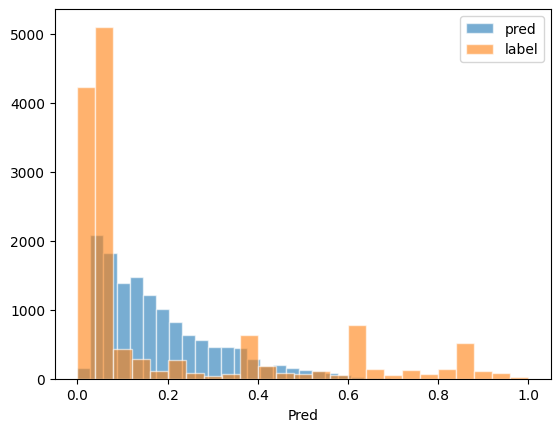

In [24]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [25]:
pred_df = test.copy()
pred_df["pred"] = np.mean(preds, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_CTVI,knn_H,knn_NDVI,knn_NormG,knn_NDWI,knn_sunAzimuth,knn_Alteration,knn_Chlred_edge,knn_SIPI2,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.580183,1.495565,-0.177638,0.448051,0.324695,127.929376,6.416499,1.554244,5.472865,0.134497
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.324673,1.544322,-0.271374,0.592326,0.597267,128.573050,4.433743,1.749661,7.369578,0.058680
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.581877,1.497484,-0.144751,0.441041,0.295492,127.929376,6.189369,1.390758,5.576378,0.096101
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024883
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.149918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038101
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021340
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.580183,1.495565,-0.177638,0.448051,0.324695,127.929376,6.416499,1.554244,5.472865,0.142303
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067879


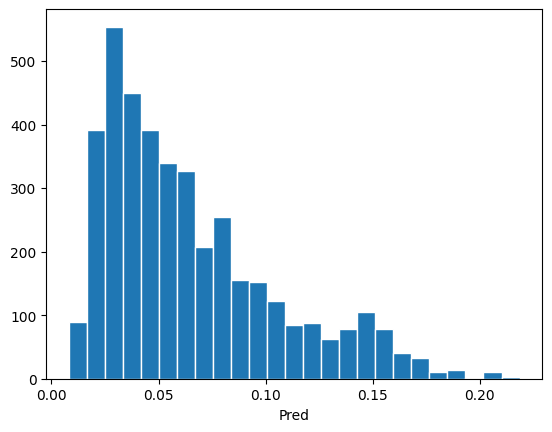

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_CTVI,knn_H,knn_NDVI,knn_NormG,knn_NDWI,knn_sunAzimuth,knn_Alteration,knn_Chlred_edge,knn_SIPI2,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.580183,1.495565,-0.177638,0.448051,0.324695,127.929376,6.416499,1.554244,5.472865,0.134497
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.324673,1.544322,-0.271374,0.592326,0.597267,128.573050,4.433743,1.749661,7.369578,0.058680
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.581877,1.497484,-0.144751,0.441041,0.295492,127.929376,6.189369,1.390758,5.576378,0.096101
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024883
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.149918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038101
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021340
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.580183,1.495565,-0.177638,0.448051,0.324695,127.929376,6.416499,1.554244,5.472865,0.142303
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067879


In [26]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else cover_max)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_SEEDAVERAGE_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)